## Imports

In [77]:
import bilby
import gwpopulation as gwpop
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner

from astropy import cosmology, units
from scipy.interpolate import interp1d
from scipy.special import erf

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
from gwpopulation.models import mass, spin

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Model B - Gaussian

This paper uses `Overall_posterior`.

In [2]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

In [3]:
file = 'GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608', '170729', '170809', '170814', 
          '170818', '170823']

posteriorsB = []
priorsB = []
event_name = []

for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['Overall_posterior'][gwtc_key]
            _prior[my_key] = ff['prior'][gwtc_key]
    posteriorsB.append(_posterior)
    priorsB.append(_prior)
    event_name.append(event)

In [4]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([cosmology.z_at_value(cosmology.Planck15.luminosity_distance, 
                                                   dl * units.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

In [5]:
for posterior in posteriorsB:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']
    
for prior in priorsB:
    prior['redshift'] = dl_to_z(prior['luminosity_distance'])
    prior['mass_1'] = prior['mass_1_det'] / (1 + prior['redshift'])
    prior['mass_2'] = prior['mass_2_det'] / (1 + prior['redshift'])
    prior['mass_ratio'] = prior['mass_2'] / prior['mass_1']

### Sampling effective spins ($\chi_{eff}$) by parameter estimation

$$\chi_{eff} = \frac{a_1 cost_1 + a_2 q cost_2}{1+q}$$

For each gravitational wave we obtain a set of discrete samples p($\chi_{eff}$|data) (given by `posterior['chieff']` here)

Effective spins are drawn from a simple truncated Gaussian.

<img src="chieff.png">


In [6]:
def chieff(a1, a2, q, cost1, cost2):
    chieff = (a1*cost1 + a2*q*cost2)/(1+q)
    return chieff

In [7]:
for posterior in posteriorsB:
    posterior['chieff'] = chieff(posterior['a_1'], posterior['a_2'], 
                                      posterior['mass_ratio'], posterior['cos_tilt_1'], posterior['cos_tilt_2'])
    
for prior in priorsB:
    prior['chieff'] = chieff(prior['a_1'], prior['a_2'], 
                                      prior['mass_ratio'], prior['cos_tilt_1'], prior['cos_tilt_2'])

<font color = 'green'>
    <h3>I have a doubt here. Should I be using this LALprior already given with the GWTC-1 catalogue, or should I simulate a new prior?</h3>
    
</font>

### We undo these default uninformative priors

- $p_{pe}(\chi_{eff}) =$ Truncated gaussian broadly peaked at 0
- Uniform mass prior
- Default redshift prior $\propto$ $D_L^2$

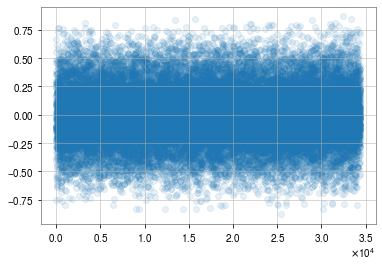

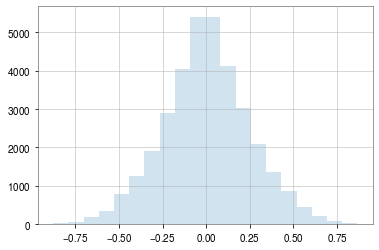

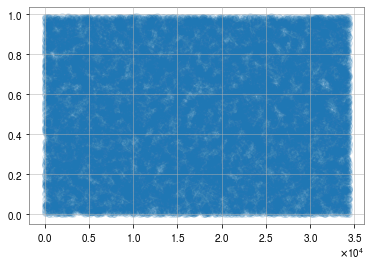

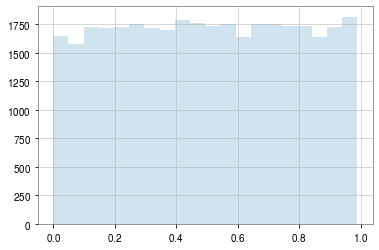

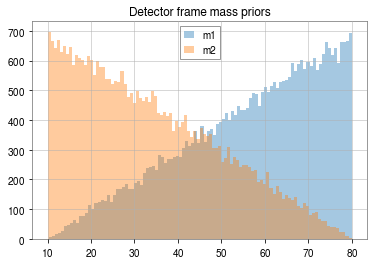

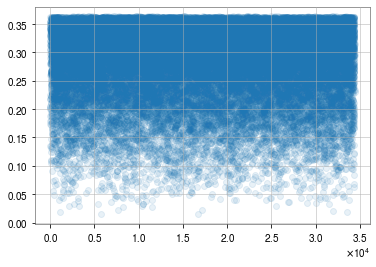

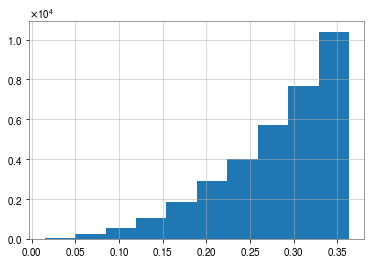

In [8]:
# These are the priors that we have to undo

# $p_{pe}(\chi_{eff}) =$ Truncated gaussian broadly peaked at 0

plt.plot(priorsB[0]['chieff'], 'o', alpha = 0.1)
plt.show()
plt.hist(priorsB[0]['chieff'], bins = 20, alpha = 0.2)
plt.show()

plt.plot(priorsB[0]['a_1'], 'o', alpha = 0.1)
plt.show()
plt.hist(priorsB[0]['a_1'], bins = 20, alpha = 0.2)
plt.show()

# plt.plot(priorsB[0]['mass_1_det'], 'o')
# plt.show()
plt.hist(priorsB[0]['mass_1_det'], bins = 100, alpha = 0.4, label = 'm1')
plt.hist(priorsB[0]['mass_2_det'], bins = 100, alpha = 0.4, label = 'm2')
plt.title('Detector frame mass priors')
plt.legend()
plt.show()

# plt.plot(priorsB[0]['mass_2_det'], 'o')
# plt.show()
# plt.hist(priorsB[0]['mass_2_det'], bins = 100)
# plt.show()

plt.plot(priorsB[0]['redshift'], 'o', alpha =0.1)
plt.show()
plt.hist(priorsB[0]['redshift'], bins = 10)
plt.show()

#### Sampling prior is given as `posterior['prior']`

In [12]:
for i in range(0, 10):
    posteriorsB[i]['redshift_prior'] = priorsB[i]['redshift']
    posteriorsB[i]['mass_prior'] = priorsB[i]['mass_1_det'] * priorsB[i]['mass_2_det']
    posteriorsB[i]['chieff_prior'] = priorsB[i]['chieff']
    posteriorsB[i]['prior'] = posteriorsB[i]['redshift_prior'] * posteriorsB[i]['mass_prior'] * posteriorsB[i]['chieff_prior']

## Hyper-prior models

### $\chi_{\mathrm{eff}}$ 

Effective spins are drawn from a simple truncated Gaussian.

<img src="chieff.png">

In [54]:
def chi_model(dataset, mu, sigma):
    prob = gwpop.utils.truncnorm(dataset['chieff'], mu, sigma, high = 1, low = -1)
    return prob

### Joint mass and redshift model:

$$p_{astro}(m_1, m_2, z) \propto \frac{(1+z)^{1.7}}{m_1(m_1 - M_{min})} \frac{dV_c}{dz}$$

where $m_1$ and $m_2$ are source frame masses.

As a first step, we assume that the underlying mass distribution does not vary across cosmic time, so that we can factor the joint mass-redshift distribution as:

$$p(m_1, m_2, z) = p(m_1, m_2) p(z)$$

This assumption may break down over a large range of redshifts, as many formation scenarios predict some dependence of the mass distribution on the merger redshift. However, LIGO is only sensitive to redshifts z <~ 1.5, for which this is a good approximation. 

<br>

<font color = 'green'>
I am highly skeptical about my implementation of the mass model. Please suggest corrections. Note that this model does not impose a maximum mass cutoff.
</font>

This is the model given in gwpop.models.redshift:

$$p(z|\gamma, \kappa, z_p) \propto \frac{1}{1 + z}\frac{dV_c}{dz} \psi(z|\gamma, \kappa, z_p)$$

$$\psi(z|\gamma, \kappa, z_p) = \frac{(1 + z)^\gamma}{1 + (\frac{1 + z}{1 + z_p})^\kappa}$$

However, I rewrote its simplified version here, (to account for f(z) as in https://arxiv.org/pdf/1805.10270.pdf (9))

In [61]:
from gwpopulation.hyperpe import HyperparameterLikelihood

# class model(HyperparameterLikelihood):
    
#     def mass_model(dataset):
    
#         '''
#         p(m1,m2|alpha, mmin) = m1^(-alpha)/(m1 - mmin)
#         Here alpha = 1 and mmin = 5
#         Not normalized
#         '''
#         prob = 1/(dataset['mass_1']*(dataset['mass_1'] - 5))
#         return prob

#     class redshift_model(gwpop.models.redshift._Redshift):
#         """
#         Redshift model from Fishbach+ https://arxiv.org/abs/1805.10270
#         Note that this is not a normalised probability.
#         """

#         def __call__(self, dataset):
#             return self.probability(dataset = dataset)

#         def psi_of_z(self, redshift, **parameters):
#             psi_of_z = 0.015 * (1 + dataset['redshift']) ** 2.7 / (1 + ((1 + dataset['redshift']) / 2.9) ** 5.6)
#             return psi_of_z


#     power_law_redshift = gwpop.models.redshift.PowerLawRedshift()

In [67]:
modelB = bilby.hyper.model.Model([chi_model])    

In [68]:
hyper_priorsB = PriorDict()
                
# mass

# redshift

# spin
hyper_priorsB['mu'] = Uniform(minimum = -1, maximum = 1, latex_label = "$$")
hyper_priorsB['sigma'] = Uniform(minimum = 0, maximum = 1, latex_label = "$$")

In [69]:
likelihoodB = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriorsB,
                                                     hyper_prior = modelB)

16:29 bilby WARNING : Cannot import cupy, falling back to numpy.


In [73]:
likelihoodB.parameters.update(hyper_priorsB.sample())
likelihoodB.log_likelihood_ratio()

-1.7976931348623157e+308

In [76]:
resultA = bilby.run_sampler(likelihood = likelihoodB, priors = hyper_priorsB, 
                            sampler='dynesty', nlive=10, label='Gaussian', outdir = 'Gaussian', clean = True)

16:47 bilby INFO    : Running for label 'Gaussian', output will be saved to 'Gaussian'
16:47 bilby INFO    : Search parameters:
16:47 bilby INFO    :   mu = Uniform(minimum=-1, maximum=1, name=None, latex_label='$$', unit=None, boundary=None)
16:47 bilby INFO    :   sigma = Uniform(minimum=0, maximum=1, name=None, latex_label='$$', unit=None, boundary=None)
16:47 bilby INFO    : Single likelihood evaluation took 1.838e-03 s



0it [00:00, ?it/s]

16:47 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 10, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 6, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f25184e3e90>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
16:47 bilby INFO    : Checkpoint every check_point_delta_t = 600s
16:47 bilby INFO    : Using dynesty version 1.0.1
16:47 bilby INFO    : Generating initial points from the prior


AttributeError: 'Dynesty' object has no attribute 'sampler'